In [0]:
###############################################################################
# SETUP - EXECUTE THIS FIRST                                                  #
###############################################################################
# 1. Go into "Runtime" -> "Change runtime type" and Select "GPU" for hardward accelerator
# 2. Click the "Connect" button, at the right to start the instance.
# This will get the dataset into this instance
!wget https://github.com/nknewlands/DeepLearningShortCourse/raw/master/Day2/Detecting%20DNA%20sites/sequences.txt
!wget https://github.com/nknewlands/DeepLearningShortCourse/raw/master/Day2/Detecting%20DNA%20sites/labels.txt
!wget https://github.com/nknewlands/DeepLearningShortCourse/raw/master/Day2/Detecting%20DNA%20sites/test.fasta
#This will install a required library
!pip install biopython

--2019-08-13 14:42:14--  https://github.com/nknewlands/DeepLearningShortCourse/raw/master/Day2/Detecting%20DNA%20sites/sequences.txt
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/nknewlands/DeepLearningShortCourse/master/Day2/Detecting%20DNA%20sites/sequences.txt [following]
--2019-08-13 14:42:14--  https://raw.githubusercontent.com/nknewlands/DeepLearningShortCourse/master/Day2/Detecting%20DNA%20sites/sequences.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15470 (15K) [text/plain]
Saving to: ‘sequences.txt.1’

sequences.txt.1     100%[===================>]  15.11K  --.-KB/s    in 0.01s   

2

Figure from : Zou, J., Huss, M., Abid, A., Mohammadi, P., Torkamani, A., & Telenti, A. (2018). A primer on deep learning in genomics. Nature genetics, 1.
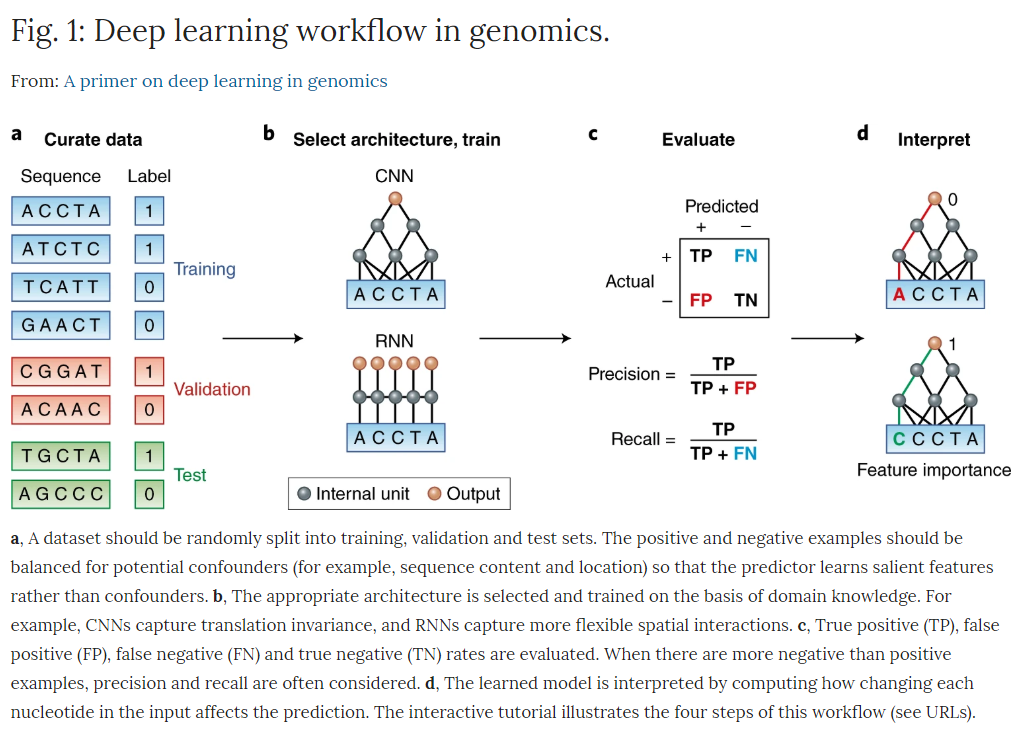

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 9, 32)             6912      
_________________________________________________________________
flatten_10 (Flatten)         (None, 288)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 16)                4624      
_________________________________________________________________
dense_21 (Dense)             (None, 2)                 34        
Total params: 11,570
Trainable params: 11,570
Non-trainable params: 0
_________________________________________________________________
Train on 331 samples, validate on 111 samples
Epoch 1/50
331/331 [==============================] - 2s 5ms/sample - loss: 0.6345 - binary_accuracy: 0.9184 - val_loss: 0.5772 - val_binary_accuracy: 0.9730
Epoch 2/50
331/331 [=======================

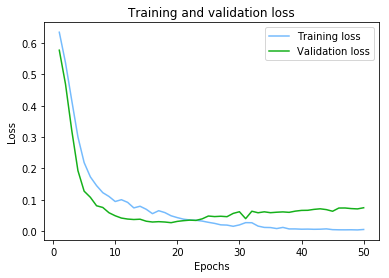

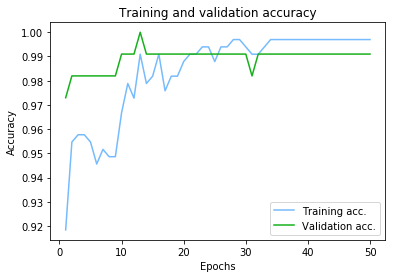

Writing results to results_LSTM.txt
[ 0/4 tr|Q2A6Z9|Q2A6Z9_PPVEA]
[ 1/4 tr|A0A2Z5UG20|A0A2Z5UG20_PPVD]
[ 2/4 sp|P17766|POLG_PPVNA]
[ 3/4 sp|Q84934|POLG_PPVSK]


<Figure size 432x288 with 0 Axes>

In [0]:
#!/usr/bin/python
#
# Original code from:  
# Zou, J., Huss, M., Abid, A., Mohammadi, P., Torkamani, A., & Telenti, A. (2018). A primer on deep learning in genomics. 
# Nat Genet. 2019 Jan;51(1):12-18. doi: 10.1038/s41588-018-0295-5.
#
# Modifications: Etienne Lord 2019
#
# See also for review: Yue, T., & Wang, H. (2018). Deep learning for genomics: A concise overview. arXiv preprint arXiv:1802.00810.
# https://arxiv.org/abs/1802.00810
#
# Identify some potential Plum pox virus protein cleaving sites.
# File: sequences.txt (Cleavage site)
#       labels.txt    (Information about each site: 0 negative, 1 positive)
#       test.fasta    (Sample fasta file)
#
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from Bio import SeqIO
import sklearn
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, LSTM
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K
from sklearn.metrics import confusion_matrix
import itertools

################################################################################ 
# PROCESS THE SITES INFORMATIONS                                               #
################################################################################

sequence_file = open("sequences.txt", "r")
sequences = sequence_file.read().split('\n')
sequences = list(filter(None, sequences))  # This removes empty sequences.
for i in range(len(sequences)):    
    sequences[i]=sequences[i].split('\t')[1]

pd.DataFrame(sequences, index=np.arange(1, len(sequences)+1),columns=['Sequences']).head()

################################################################################ 
# ENCODE THE DNA INFORMATION USING ONE HOT ENCODING                            #
################################################################################
# The LabelEncoder encodes a sequence of bases as a sequence of integers.

integer_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(categories=[range(21)])   # 21 Amino acid
input_features = []
for sequence in sequences:
  integer_encoded = integer_encoder.fit_transform(list(sequence))
  integer_encoded = np.array(integer_encoded).reshape(-1, 1)
  one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
  input_features.append(one_hot_encoded.toarray())

input_features = np.stack(input_features)

################################################################################ 
# LOAD LABELS FOR EACH SITES AND ENCODE                                        #
################################################################################
label_file = open("labels.txt", "r")

labels = label_file.read().split('\n')
labels = list(filter(None, labels))  # removes empty sequences
for i in range(len(labels)):    
    labels[i]=labels[i].split('\t')[1]

one_hot_encoder2 = OneHotEncoder(categories=[range(2)]) #2 states: 0 or 1
labels = np.array(labels).reshape(-1, 1)
input_labels = one_hot_encoder2.fit_transform(labels).toarray()

## SPLIT THE TRAINING DATA 75% TRAINING / 25% VALIDATION
train_features, test_features, train_labels, test_labels = train_test_split(input_features, input_labels, test_size=0.25, random_state=42)

################################################################################ 
# MODEL DEFINITION (LSTM, one layer)                                            #
################################################################################
model = Sequential()
model.add(LSTM(32, dropout=0.01, return_sequences=True, input_shape=(train_features.shape[1], 21)))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=['binary_accuracy'])
model.summary()

################################################################################ 
# MODEL DEFINITION (1D CNN)                                                    #
################################################################################
# Model
#model = Sequential() # Adjust the conv size
#model.add(Conv1D(filters=32, kernel_size=5,input_shape=(train_features.shape[1], 21)))
#model.add(MaxPooling1D(pool_size=4))
#model.add(Flatten())
#model.add(Dense(16, activation='relu'))
#model.add(Dense(2, activation='softmax'))

#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
#model.summary()


################################################################################ 
# RUN MODEL                                                                    #
################################################################################
history = model.fit(train_features, train_labels,epochs=50, verbose=1, validation_data=[test_features,test_labels])

predicted_labels = model.predict(np.stack(test_features))
cm = confusion_matrix(np.argmax(test_labels, axis=1), 
                      np.argmax(predicted_labels, axis=1))
# 
# True 0  [62  0]
#      1  [1  48]
#          0   1
#        Predited
# Note: show overfitting after ~25 epochs.  
print('Confusion matrix:\n',cm)

################################################################################ 
# VISUALIZE THE TRAINING RESULTS                                               #
################################################################################

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Colors are from are color from https://xkcd.com/color/rgb/
plt.plot(epochs, loss, 'xkcd:sky blue', label='Training loss')
plt.plot(epochs, val_loss, 'xkcd:green', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('loss.png', bbox_inches='tight')

plt.clf()   # New figure

plt.plot(epochs, acc, 'xkcd:sky blue', label='Training acc.')
plt.plot(epochs, val_acc, 'xkcd:green', label='Validation acc.')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.savefig('accuracy.png', bbox_inches='tight')

################################################################################ 
# TEST ON REAL DATA (test.fasta)                                               #
################################################################################
## Now scanning the sequence
def load_fasta(fa_file):
    # Variable data 
    data = []

    # Open the sequences file
    for record in SeqIO.parse(fa_file, "fasta"):
            data.append([record.id, record.seq.upper(), None])
    # Return data
    return data

proteome=load_fasta("test.fasta")
df=pd.DataFrame(columns=['name','sequence','probs','max_score'])
file = open("results_LSTM.txt","w") 
print("Writing results to results_LSTM.txt")
## Predict for each sequence of len 9 AA
for i in range(len(proteome)):
    seqname=proteome[i][0]
    print('[ %d/%d %s]'%(i,len(proteome),seqname))
    seq=str(proteome[i][1])
    seqlist=list()
    by=1
    for j in range(0,len(seq),by):
        to_test=seq[j:(j+9)]
        seqlist.append(to_test)       
        #input_sequence=list()
    seq_features = []
    for sequence in seqlist:            
            if len(sequence)==9:
                integer_encoded = integer_encoder.fit_transform(list(sequence))
                integer_encoded = np.array(integer_encoded).reshape(-1, 1)
                one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
                #Remove the end of sequence            
                seq_features.append(one_hot_encoded.toarray())  
    if len(seq_features)>1:
        predicted_labels = model.predict(np.stack(seq_features))    
        file.write("%s\t%f\t%s\t%s\n"%(seqname,np.max(predicted_labels[:,1]),seq,','.join(map(str, predicted_labels[:,1]))))
file.close()
################################################################################ 
# FINAL NOTES                                                                  #
################################################################################
#
# 1. This is a modification of the 1D CNN approach with memory cells (LSTM)
# 2. A modification could imply the use of longer sequence lengths.

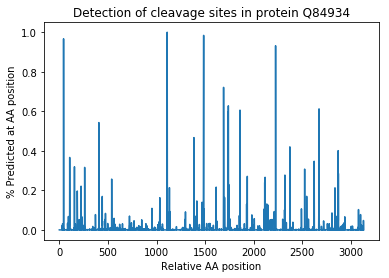

In [0]:
# Note, we predicted with a window of 9 AA so the first position if from 
# AA 1 to 9, second 2 to 10, third 3 to 12...
# This show an hotspot 
plt.clf()
plt.plot(predicted_labels[:,1])
plt.title('Detection of cleavage sites in protein Q84934')
plt.xlabel('Relative AA position')
plt.ylabel('% Predicted at AA position')
plt.show()